In [1]:
from collections import defaultdict
import math
import time
import copy
import itertools
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from PIL import Image, ImageFile
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter('../runs/cat_fish_cnn_{}'.format(datetime.now()))

ImageFile.LOAD_TRUNCATED_IMAGES=True

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
transform = transforms.Compose([
    transforms.Resize([227, 227]),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])


def get_data(batch_size=64):
    phases = ['train', 'val', 'test']
    path = "../dataset/cat_fish/{}/"
    image_sets = {phase: torchvision.datasets.ImageFolder(root=path.format(phase), transform=transform)
           for phase in phases}
    data_loader = {phase: data.DataLoader(image_sets[phase], batch_size=batch_size) 
                  for phase in phases}
    
    print(f"Number of training images: {len(image_sets['train'])}")
    print(f"Number of validation images: {len(image_sets['val'])}")
    print(f"Number of testing images: {len(image_sets['test'])}")
    print(f"Size of each image: {image_sets['train'][0][0].size()}")

    return data_loader

In [4]:
data_loader = get_data()

Number of training images: 806
Number of validation images: 108
Number of testing images: 161
Size of each image: torch.Size([3, 227, 227])


## show some images

In [5]:
def imshow(tensor, ax=None):
    np_img = tensor.permute(1, 2, 0)
    if not ax:
        _, ax = plt.subplots()
    ax.imshow(np_img.astype(np.uint8))
    plt.axis('off')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


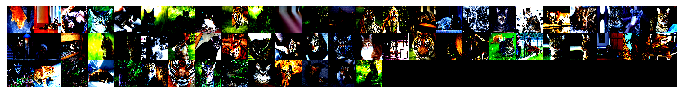

In [6]:
# get some random training images
data_iter = iter(data_loader['train'])
sample_images, labels = data_iter.next()
# show images
fig, ax = plt.subplots(figsize=(12, 4))
grid = torchvision.utils.make_grid(sample_images, nrow=25)
# write to tensorboard
writer.add_image('cat_fish', grid)
imshow(grid, ax=ax)

# Using pretrained models

In [7]:
alexnet = models.alexnet(num_classes=2)

In [15]:
alexnet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [8]:
# inspect model in tensorboard
writer.add_graph(alexnet, sample_images)

In [9]:
classes = ['Cat', 'Fish']

In [10]:
# helper functions

# helper function to show an image
# (used in the `plot_classes_preds` function below)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy().astype(np.uint8)
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))


def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure()
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx])
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [12]:
optimizer = optim.SGD(alexnet.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## training

In [13]:
def train(model, optimizer, criterion, data_loader, epochs=5):
    model = model.to(device)
    # define training variables
    since = time.time()
    best_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 60)    

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in data_loader[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # make predictions
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            batch_size = len(data_loader[phase].dataset)
            epoch_loss = running_loss / batch_size
            epoch_acc = running_corrects.double() / batch_size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # ...log the running loss to tensorboard
            writer.add_scalar('{}/loss'.format(phase), epoch_loss, epoch)
            writer.add_scalar('{}/accuracy'.format(phase), epoch_acc.item(), epoch)
            
            if phase == 'val':
                # ...log a Matplotlib Figure showing the model's predictions on a
                # random mini-batch
                writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc.item()
                best_weights = copy.deepcopy(model.state_dict())
            

    time_elapsed = time.time() - since
    print('-' * 60)
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:.3f} %'.format(100 * best_acc))
    print('=' * 60, '\n')
    # load best weights
    model.load_state_dict(best_weights)
    model = model.to(device)
    return model

In [14]:
m = train(alexnet, optimizer, criterion, data_loader, epochs=5)

Epoch 1/5
------------------------------------------------------------
train Loss: 0.7009 Acc: 0.2258
val Loss: 0.6853 Acc: 0.8148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 2/5
------------------------------------------------------------
train Loss: 0.6970 Acc: 0.5273
val Loss: 0.6825 Acc: 0.8148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 3/5
------------------------------------------------------------
train Loss: 0.6957 Acc: 0.5273
val Loss: 0.6823 Acc: 0.8148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 4/5
------------------------------------------------------------
train Loss: 0.6953 Acc: 0.5273
val Loss: 0.6826 Acc: 0.8148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch 5/5
------------------------------------------------------------
train Loss: 0.6949 Acc: 0.5273
val Loss: 0.6830 Acc: 0.8148


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------
Training complete in 4m 7s
Best val Acc: 81.481 %

